In [65]:
import pdb

import cv2
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import torch.nn.functional as F
from torchvision.models import VGG
from torchvision.models.vgg import cfg, model_urls
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader

from ssdmultibox.datasets import TrainPascalDataset, open_image
from ssdmultibox.plotting import *

np.set_printoptions(precision=15)

# Dataset and DataLoader

In [31]:
dataset = TrainPascalDataset()

In [37]:
dataloader = DataLoader(dataset, batch_size=4, num_workers=0)

# Model

In [3]:
def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

def vgg16(pretrained=False, **kwargs):
    """VGG 16-layer model (configuration "D")

    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfg['D']), **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['vgg16']))
    return model

In [4]:
model = vgg16(pretrained=True)

In [5]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (17): Conv2d(25

# SSD auxiliary network

In [6]:
# setup blocks to capute SSD parameters

feat_layers=['block4', 'block7', 'block8', 'block9', 'block10', 'block11']
blocks = {b:None for b in feat_layers}
blocks

{'block4': None,
 'block7': None,
 'block8': None,
 'block9': None,
 'block10': None,
 'block11': None}

In [7]:
# TODO: make `grid_size=4` a default
grid_size = 4
dataset = TrainPascalDataset()

In [8]:
image_paths = dataset.images()

In [9]:
image_id = 17
image_path = image_paths[image_id]

In [10]:
im = open_image(image_path)
im.shape

(364, 480, 3)

In [11]:
SIZE = 300
im = cv2.resize(im, (SIZE, SIZE))
im.shape

(300, 300, 3)

In [12]:
tim = torch.tensor(im)
tim.shape

torch.Size([300, 300, 3])

In [13]:
tim = tim.permute(2, 0, 1)
tim.shape

torch.Size([3, 300, 300])

In [14]:
tim = tim.unsqueeze(0)
tim.shape

torch.Size([1, 3, 300, 300])

In [15]:
tim.shape

torch.Size([1, 3, 300, 300])

In [16]:
# VGG16 base network output
outputs = model.features(tim)
outputs.shape

torch.Size([1, 512, 10, 10])

## block4

In [17]:
x = tim
for i, f in enumerate(model.features):
    print(i, x.shape, model.features[i])
    x = model.features[i](x)
    if i == 22:
        blocks['block4'] = x
    
    # don't call the final max_pool layer b/c we want an output shape of (512, 19, 19)
    if i == 29:
        break

print('block4:', blocks['block4'].shape)
print('base output:', x.shape)

0 torch.Size([1, 3, 300, 300]) Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 torch.Size([1, 64, 300, 300]) ReLU(inplace)
2 torch.Size([1, 64, 300, 300]) Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 torch.Size([1, 64, 300, 300]) ReLU(inplace)
4 torch.Size([1, 64, 300, 300]) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
5 torch.Size([1, 64, 150, 150]) Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 torch.Size([1, 128, 150, 150]) ReLU(inplace)
7 torch.Size([1, 128, 150, 150]) Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 torch.Size([1, 128, 150, 150]) ReLU(inplace)
9 torch.Size([1, 128, 150, 150]) MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
10 torch.Size([1, 128, 75, 75]) Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 torch.Size([1, 256, 75, 75]) ReLU(inplace)
12 torch.Size([1, 256, 75, 75]) Conv2d(256, 256, kernel_size=

## block 6 + 7

In [18]:
conv6 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
out6 = F.dropout2d(F.relu(conv6(x)))
out6.shape

torch.Size([1, 1024, 19, 19])

In [19]:
conv7 = nn.Conv2d(1024, 1024, kernel_size=1)
out7 = F.dropout2d(F.relu(conv7(out6)))
blocks['block7'] = out7
out7.shape

torch.Size([1, 1024, 19, 19])

In [20]:
blocks.keys()

dict_keys(['block4', 'block7', 'block8', 'block9', 'block10', 'block11'])

## Block 8/9/10/11

block8

In [21]:
conv8 = nn.Conv2d(1024, 256, kernel_size=1, padding=1)
out8 = F.relu(conv8(out7))
out8.shape

torch.Size([1, 256, 21, 21])

In [22]:
conv8_2 = nn.Conv2d(256, 512, kernel_size=3, stride=2)
out8_2 = F.relu(conv8_2(out8))
blocks['block8'] = out8_2
out8_2.shape

torch.Size([1, 512, 10, 10])

block9

In [23]:
conv9 = nn.Conv2d(512, 128, kernel_size=1, padding=1)
out9 = F.relu(conv9(out8_2))
out9.shape

torch.Size([1, 128, 12, 12])

In [24]:
conv9_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
out9_2 = F.relu(conv9_2(out9))
blocks['block9'] = out9_2
out9_2.shape

torch.Size([1, 256, 5, 5])

block10

In [25]:
conv10 = nn.Conv2d(256, 128, kernel_size=1, padding=1)
out10 = F.relu(conv10(out9_2))
out10.shape

torch.Size([1, 128, 7, 7])

In [26]:
conv10_2 = nn.Conv2d(128, 256, kernel_size=3, stride=2)
out10_2 = F.relu(conv10_2(out10))
blocks['block10'] = out10_2
out10_2.shape

torch.Size([1, 256, 3, 3])

block11

In [27]:
conv11 = nn.Conv2d(256, 128, kernel_size=1)
out11 = F.relu(conv11(out10_2))
out11.shape

torch.Size([1, 128, 3, 3])

In [28]:
conv11_2 = nn.Conv2d(128, 256, kernel_size=3)
out11_2 = F.relu(conv11_2(out11))
blocks['block11'] = out11_2
out11_2.shape

torch.Size([1, 256, 1, 1])

In [29]:
for k,v in blocks.items():
    print(k, v.shape)

block4 torch.Size([1, 512, 38, 38])
block7 torch.Size([1, 1024, 19, 19])
block8 torch.Size([1, 512, 10, 10])
block9 torch.Size([1, 256, 5, 5])
block10 torch.Size([1, 256, 3, 3])
block11 torch.Size([1, 256, 1, 1])


feature_maps

In [30]:
feature_maps = [v.shape[-1] for k,v in blocks.items()]
feature_maps

[38, 19, 10, 5, 3, 1]

# NEXT: Custom head needs to output (c + 4)k

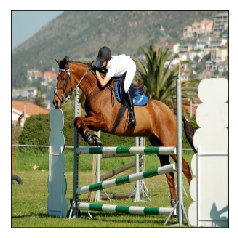

In [42]:
show_img(im)

In [43]:
300 / 5

60.0

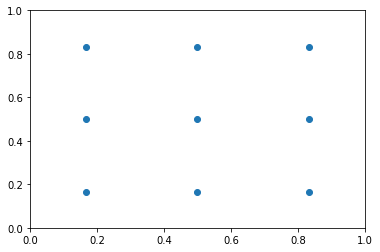

In [44]:
def get_anchor_centers(anc_grid):
    anc_offset = 1/(anc_grid*2)
    anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
    anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
    anc_ctrs = np.stack([anc_x,anc_y], axis=1)
    return anc_ctrs

anc_ctrs = get_anchor_centers(3)

anc_x = anc_ctrs[:,0]
anc_y = anc_ctrs[:,1]

plt.scatter(anc_x, anc_y)
plt.xlim(0, 1)
plt.ylim(0, 1);

In [45]:
anc_ctrs

array([[0.166666666666667, 0.166666666666667],
       [0.166666666666667, 0.5              ],
       [0.166666666666667, 0.833333333333333],
       [0.5              , 0.166666666666667],
       [0.5              , 0.5              ],
       [0.5              , 0.833333333333333],
       [0.833333333333333, 0.166666666666667],
       [0.833333333333333, 0.5              ],
       [0.833333333333333, 0.833333333333333]])

In [46]:
# square anchors
anc_grid = 3
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anc_sizes # they're all this size

array([[0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333],
       [0.333333333333333, 0.333333333333333]])

In [47]:
# feature map cell default hw
sk = 1/anc_grid
w = 2. * sk
h = 1. * sk
np.reshape(np.repeat([w, h], anc_grid*anc_grid), (2,-1)).T

array([[0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [0.666666666666667, 0.333333333333333]])

In [48]:
def hw2corners(center, hw):
    return np.concatenate([center-hw/2, center+hw/2], axis=1)

anchor_corners = hw2corners(anc_ctrs, anc_sizes)
anchor_corners

array([[0.               , 0.               , 0.333333333333333, 0.333333333333333],
       [0.               , 0.333333333333333, 0.333333333333333, 0.666666666666667],
       [0.               , 0.666666666666667, 0.333333333333333, 1.               ],
       [0.333333333333333, 0.               , 0.666666666666667, 0.333333333333333],
       [0.333333333333333, 0.333333333333333, 0.666666666666667, 0.666666666666667],
       [0.333333333333333, 0.666666666666667, 0.666666666666667, 1.               ],
       [0.666666666666667, 0.               , 1.               , 0.333333333333333],
       [0.666666666666667, 0.333333333333333, 1.               , 0.666666666666667],
       [0.666666666666667, 0.666666666666667, 1.               , 1.               ]])

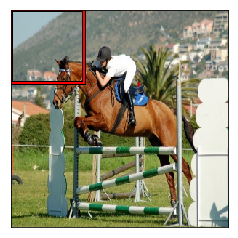

In [49]:
SIZE = 300
ax = show_img(im)
for i, bbox in enumerate(anchor_corners):
    if i == 0:
        draw_rect(ax, bbox*SIZE, edgecolor='red')

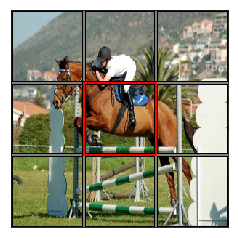

In [50]:
ax = show_img(im)
xy = np.array([1/3, 1/3]) * SIZE
width = height = 1/3 * SIZE

# grid
for i, bbox in enumerate(anchor_corners):
    draw_rect(ax, bbox*SIZE, edgecolor='grey')

# focus default box
ax.add_patch(patches.Rectangle(xy, width, height, fill=False, edgecolor='red', lw=2))

In [51]:
width

100.0

In [52]:
np.sqrt(.2*.2+1)

1.019803902718557

`sk` is based upon the `grid_size`

```python
grid_size = 5
hw = (1,1)
sk = grid_size / hw
sk ~ 1
```

In [53]:
sk = 1/3

In [54]:
# aspect ration
ar = np.array([
    (1., 1.), 
    (2., 1.),
    (3., 1.),
    (1., 2.),
    (1., 3.),
    (np.sqrt(sk*sk+1), 1.)
])
ar

array([[1.              , 1.              ],
       [2.              , 1.              ],
       [3.              , 1.              ],
       [1.              , 2.              ],
       [1.              , 3.              ],
       [1.05409255338946, 1.              ]])

In [55]:
# width, heigh
wh = sk * ar
wh

array([[0.333333333333333, 0.333333333333333],
       [0.666666666666667, 0.333333333333333],
       [1.               , 0.333333333333333],
       [0.333333333333333, 0.666666666666667],
       [0.333333333333333, 1.               ],
       [0.351364184463153, 0.333333333333333]])

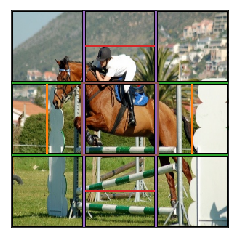

In [56]:
center = anc_ctrs
hw = wh[0]
anc_corners = np.concatenate([center-hw/2, center+hw/2], axis=1)
ax = show_img(im)
# grid
for i, bbox in enumerate(anchor_corners):
    draw_rect(ax, bbox*SIZE, edgecolor='white')
    
for j, hw in enumerate(wh):
    x1 = anc_ctrs[:,0]-hw[0]/2
    y1 = anc_ctrs[:,1]-hw[1]/2
    x2 = anc_ctrs[:,0]+hw[0]/2
    y2 = anc_ctrs[:,1]+hw[1]/2
    anc_corners = np.stack([x1,y1,x2,y2], axis=1)
    for i, bbox in enumerate(anc_corners):
        # focus default box
        if i == 4:
            xy = np.array(bbox[:2])*SIZE
            width = (bbox[2] - bbox[0])*SIZE
            height = (bbox[3] - bbox[1])*SIZE
            ax.add_patch(patches.Rectangle(xy, width, height, fill=False, edgecolor=f'C{j}', lw=2))
            break

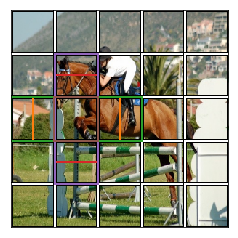

In [57]:
grid_size = 5
sk = 1 / 5
anc_ctrs = dataset.bboxer.anchor_centers(grid_size)
anc_corners = dataset.bboxer.anchor_corners(grid_size)

# image
ann = dataset.get_annotations()[17]
im = open_image(ann['image_path'])
ax = show_img(cv2.resize(im, (SIZE, SIZE)))

# grid
for i, bbox in enumerate(anc_corners):
    draw_rect(ax, bbox*SIZE, edgecolor='white')

for j, hw in enumerate(dataset.bboxer.aspect_ratios(grid_size)):
    hw = hw * sk
    x1 = anc_ctrs[:,0]-hw[0]/2
    y1 = anc_ctrs[:,1]-hw[1]/2
    x2 = anc_ctrs[:,0]+hw[0]/2
    y2 = anc_ctrs[:,1]+hw[1]/2
    anc_corners = np.stack([x1,y1,x2,y2], axis=1)
    for i, bbox in enumerate(anc_corners):
        # focus default box
        if i == 7:
            xy = np.array(bbox[:2])*SIZE
            width = (bbox[2] - bbox[0])*SIZE
            height = (bbox[3] - bbox[1])*SIZE
            ax.add_patch(patches.Rectangle(xy, width, height, fill=False, edgecolor=f'C{j}', lw=2))
            break

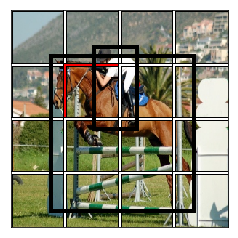

In [75]:
bboxer = dataset.bboxer
grid_size = 4
sk = 1 / grid_size
anc_ctrs = dataset.bboxer.anchor_centers(grid_size)
anc_corners = dataset.bboxer.anchor_corners(grid_size)

# image
ann = dataset.get_annotations()[17]
im = open_image(ann['image_path'])
ax = show_img(cv2.resize(im, (SIZE, SIZE)))

for i, bbox in enumerate(bboxer.anchor_corners(grid_size)):
    if i == 5:
        color = 'red'
    else:
        color = 'white'
    draw_rect(ax, bbox*SIZE, edgecolor=color)

horse_bb = dataset.bboxer.pascal_bbs(np.expand_dims(np.reshape(gt_bbs[3][0], (-1,4))[7], axis=0)).squeeze()
draw_rect(ax, horse_bb, edgecolor='black')
person_bb = dataset.bboxer.pascal_bbs(np.expand_dims(np.reshape(gt_bbs[3][0], (-1,4))[11], axis=0)).squeeze()
draw_rect(ax, person_bb, edgecolor='black')

In [63]:
image_id, chw_im, gt_bbs, gt_cats = item

In [67]:
# 5x5 grid_size, 1:1 aspect ratio
gt_cats[3][0]

array([20, 20, 20, 20, 20, 20, 20, 14, 20, 20, 20, 12, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20])

In [71]:
np.where(gt_cats[3][0] != 20)[0]

array([ 7, 11])

In [77]:
bbs = ann['bbs']
bbs = np.array(bbs)
bbs

array([[184,  61,  95, 138],
       [ 89,  77, 314, 259]])

In [78]:
im.shape

(364, 480, 3)

In [79]:
bboxer.get_bbs_area(bbs, im)

array([0.073121993284493, 0.460923504273504])

In [82]:
bbs[:,2:]

array([[ 95, 138],
       [314, 259]])

In [85]:
95*138

13110

In [86]:
364*480

174720

In [87]:
(95*138) / (364*480)

0.07503434065934066

In [88]:
(314*259) / (364*480)

0.4654647435897436

In [89]:
bboxer.get_ancb_area(grid_size)

0.0625

In [91]:
bboxer.get_iou(bbs, im).argmax(1)

array([5, 5])

In [93]:
gt_overlap, gt_idx = bboxer.get_gt_overlap_and_idx(bbs, im)
gt_overlap, gt_idx

(tensor([0.0047, 0.0709, 0.0474, 0.0063, 0.0308, 1.9900, 0.1436, 0.0412, 0.0308,
         0.1194, 0.1194, 0.0412, 0.0209, 0.0811, 0.0811, 0.0280],
        dtype=torch.float64),
 tensor([1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

In [97]:
gt_overlap.max(0)

(tensor(1.9900, dtype=torch.float64), tensor(5))

In [99]:
gt_idx[5]

tensor(1)

In [100]:
gt_overlap > .5

tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=torch.uint8)

In [101]:
cats = np.array(ann['cats'])
cats

array([14, 12])

In [103]:
gt_bbs, gt_cats = bboxer.get_gt_bbs_and_cats(bbs, cats, im)
gt_bbs, gt_cats

(array([ 63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003,  50.27472527472527,
        115.00000000000001, 163.010989010989  , 173.37500000000003,  50.27472527472527, 115.00000000000001,
        163.010989010989  , 173.37500000000003,  63.46153846153846,  55.625           , 275.92307692307696,
        250.87500000000003,  63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003,
         63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003,  50.27472527472527,
        115.00000000000001, 163.010989010989  , 173.37500000000003,  63.46153846153846,  55.625           ,
        275.92307692307696, 250.87500000000003,  63.46153846153846,  55.625           , 275.92307692307696,
        250.87500000000003,  63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003,
         63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003,  63.46153846153846,
         55.625           , 

In [106]:
np.reshape(gt_bbs, (-1,4))[5]

array([ 63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003])

In [107]:
bbs

array([[184,  61,  95, 138],
       [ 89,  77, 314, 259]])

In [109]:
bboxer.scaled_fastai_bbs(bbs, im) * SIZE

array([[ 50.27472527472527, 115.00000000000001, 163.010989010989  , 173.37500000000003],
       [ 63.46153846153846,  55.625           , 275.92307692307696, 250.87500000000003]])

In [110]:
cats

array([14, 12])

In [111]:
dataset.categories()[12]

'horse'

In [84]:
im.shape

(364, 480, 3)

In [ ]:
cv2.resize(im, (SIZE, SIZE))

In [ ]:
bboxer.anchor_corners(grid_size=4)

In [ ]:
bbs

In [ ]:
bbs = bboxer.scaled_fastai_bbs(ann['bbs'], im)
bbs

In [ ]:
bbs_count = grid_size*grid_size
bbs_count

In [ ]:
bbs16 = np.reshape(np.tile(bbs, bbs_count), (-1,bbs_count,4))
print(bbs16.shape)
bbs16

In [ ]:
anchor_corners = bboxer.anchor_corners(grid_size)
anchor_corners

In [ ]:
bbs

In [ ]:
np.maximum(anchor_corners[:,:2], bbs16[:,:,:2])

In [ ]:
np.minimum(anchor_corners[:,2:], bbs16[:,:,2:])

In [ ]:
intersect = np.minimum(
    np.maximum(anchor_corners[:,:2], bbs16[:,:,:2]) - \
    np.minimum(anchor_corners[:,2:], bbs16[:,:,2:]), 0)
intersect

In [ ]:
ret = intersect[:,:,0] * intersect[:,:,1]
ret

In [ ]:
ret.argmax(1)

In [ ]:
def intersect(box_a, box_b):
    max_xy = torch.min(box_a[:, None, 2:], box_b[None, :, 2:])
    min_xy = torch.max(box_a[:, None, :2], box_b[None, :, :2])
    inter = torch.clamp((max_xy - min_xy), min=0)
    return inter[:, :, 0] * inter[:, :, 1]

def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))

def jaccard(box_a, box_b):
    inter = intersect(box_a, box_b)
    union = box_sz(box_a).unsqueeze(1) + box_sz(box_b).unsqueeze(0) - inter
    return inter / union

In [ ]:
np.minimum(1, 0)

In [ ]:
t_bbs = torch.tensor(bbs)
t_anchor_corners = torch.tensor(anchor_corners)
inter = intersect(t_bbs, t_anchor_corners)
inter

In [ ]:
inter.max(1)

In [ ]:
iou = jaccard(t_bbs, t_anchor_corners)
iou

In [ ]:
iou.max(1)

In [ ]:
iou.max(0)

In [ ]:
anchor_corners